# Final project GenAI

LEARNING GRADIENTS OF CONVEX FUNCTIONS WITH MONOTONE GRADIENT NETWORKS

arXiv:2301.10862v2

Librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# import pickle
# import os

# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.model_selection import train_test_split

import torch
# from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

SetUp

In [2]:
# Set default tensor type to FloatTensor
torch.set_default_dtype(torch.float64)

# default device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')
  
# default tensor type  
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.DoubleTensor')
else:
    torch.set_default_tensor_type('torch.DoubleTensor')

Using device: cuda
GPU Name: NVIDIA GeForce RTX 3080
Total GPU Memory: 9.8 GB


/home/benjamin.deporte/.conda/envs/learning_gradients/lib/python3.12/site-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/envs/bld/conda-bld/libtorch_1741644046984/work/torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


In [3]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed for reproducibility
seed_everything(42)

### Model classes

C-MGN : Note that the nn.Parameter in PyTorch is what allows to share a weight matrix within the model

In [13]:
class CMGN(nn.Module):
    def __init__(self, input_dim, output_dim, num_layers, hidden_dim):
        super(CMGN, self).__init__()
        """Constructor. 
        - input_dim: int, dimension of input data
        - output_dim: int, dimension of output data
        - num_layers: int, number of layers in the model
        - hidden_dim: int, dimension of hidden layers
        """
        self.num_layers = num_layers
        # nn.ModuleList : "Holds submodules in a list" (PyTorch documentation)
        self.sigma_layers = nn.ModuleList([nn.Sigmoid() for _ in range(num_layers)])
        # nn.Parameter : "A kind of Tensor that is to be considered a module parameter."
        # this is how we create a weight matrix that is shared across all layers
        # NB : requires_grad=True by default
        self.W = nn.Parameter(torch.randn(input_dim, hidden_dim)) 
        self.V = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.b_L = nn.Parameter(torch.randn(output_dim))
        # nn.ParameterList : "Holds parameters in a list" (PyTorch documentation)
        self.biases = nn.ParameterList([nn.Parameter(torch.randn(hidden_dim)) for _ in range(num_layers)])

    def forward(self, x):
        """Forward pass of the model.

        Args:
            x (tensor): input data. Shape (batch_size, input_dim)
        Returns:
            output (tensor) : output data. Shape (batch_size, output_dim)
        """

        # compute z_0
        Wx = F.linear(x, self.W)
        z = Wx + self.biases[0] 
        # compute z_1, z_2, ..., z_{L-1} with the shared weight matrix W
        for i in range(1,self.num_layers):
            z = Wx + self.sigma_layers[i-1](z) + self.biases[i]
        # compute V^T V x
        VTVx = F.linear(F.linear(x, self.V.t()), self.V)
        # compute W sigma_L
        Wsigma = F.linear(self.sigma_layers[self.num_layers-1](z), self.W.T)
        # add everything together
        output = Wsigma + VTVx + self.b_L
        return output

M-MGN

In [14]:
class MMGN(nn.Module):
    def __init__(self, input_dim, output_dim, num_modules, hidden_dim):
        super(MMGN, self).__init__()
        """Constructor. Same as C-MGN
        - input_dim: int, dimension of input data
        - output_dim: int, dimension of output data
        - num_modules: int, number of modules in parallel
        - hidden_dim: int, dimension of hidden layers
        """
        self.num_modules = num_modules
        self.W_list = nn.ParameterList([nn.Parameter(torch.randn(input_dim, hidden_dim)) for _ in range(num_modules)])
        self.biases = nn.ParameterList([nn.Parameter(torch.randn(hidden_dim)) for _ in range(num_modules)])
        # activation function : from the paper
        self.activation = nn.Tanh()

        self.V = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.a = nn.Parameter(torch.randn(output_dim))

    def forward(self, x):
        # s_k : from the paper
        def log_cosh(x):
          return torch.sum( torch.log(torch.cosh(x)) )

        sum = 0
        for i in range(self.num_modules):
            Wx = F.linear(x, self.W_list[i].T)
            z = Wx + self.biases[i]
            Wsigma = F.linear(self.activation(z), self.W_list[i])
            sum += log_cosh(z) * Wsigma
        VTVx = F.linear(F.linear(x, self.V), self.V.t())

        output = self.a + VTVx + sum 
        return output

### Toy Case #1 : Gradient field experiment

Gradient field experiment from the paper.

The convex function is $f: \mathbb{R}^2 \rightarrow \mathbb{R}$:
\begin{equation}
f(x) = x_1^4 + \frac{x_1^2}{2} +  \frac{x_1 x_2}{2}  + \frac{3x_2^2}{2} -  \frac{x_2^3}{3}
\end{equation}

The gradient field to learn, ie the transport map, is:
\begin{equation}
T(x_1,x_2) = \begin{pmatrix}
4x_1^3 + \frac{1}{2}x_2 + x_1 \\
3x_2 - x_2^2 + \frac{1}{2}x_1
\end{pmatrix}
\end{equation}

In [15]:
def f(z):
  x = z[:,0]
  y = z[:,1]
  return torch.stack([x**4 + 0.5*y**2 + 0.5 * x* y + 1.5 * y**2 - y**3/3]).T

In [16]:
def g(z):
    x = z[:,0]
    y = z[:,1]
    return torch.stack([4*x**3 + 0.5*y + x, 3*y - y**2 + 0.5*x ]).T

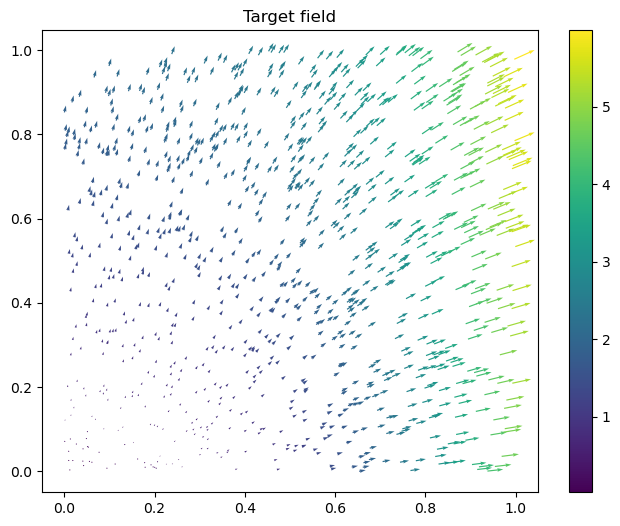

In [17]:
# Plot field (gradient)
space = torch.rand(size=(1000,2)).cpu()
fig,ax = plt.subplots(1,1,figsize=(8,6))

z = g(space)
p = ax.quiver(space[:,0],space[:,1], z[:,0],z[:,1],z.norm(dim=1))
ax.set_title('Target field')
plt.colorbar(p)
plt.show()

In [43]:
def train_gradient_field(mod,num_epochs=10000,dim=2,batch_size=100,lr=1e-2):
    optimizer = torch.optim.Adam(mod.parameters(),lr=lr)
    for i in range(num_epochs):
        input = torch.rand(size=(batch_size,dim))
        out = mod(input)
        target = g(input)

        loss = (out - target).abs().sum() / batch_size

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if not i % 1000: 
            print(f"epoch {i}/{num_epochs}, loss = {loss.item():4e}", end="\r")

In [47]:
model_MMGN = MMGN(input_dim=2, output_dim=2,num_modules=1, hidden_dim=4)
model_CMGN = CMGN(input_dim=2, output_dim=2, num_layers=2, hidden_dim=2)

dim = 2
bsize = 100
epochs_cmgn = 10000
epochs_mmgn = 100000

print("Training C-MGN...")
# summary_model(model_CMGN)
train_gradient_field(model_CMGN,num_epochs=epochs_cmgn,dim=dim,batch_size=bsize)

print()
print("Training M-MGN...")
# summary_model(model_MMGN)
train_gradient_field(model_MMGN,num_epochs=epochs_mmgn,dim=dim,batch_size=bsize, lr=1e-4)

Training C-MGN...
epoch 9000/10000, loss = 8.210300e-02
Training M-MGN...


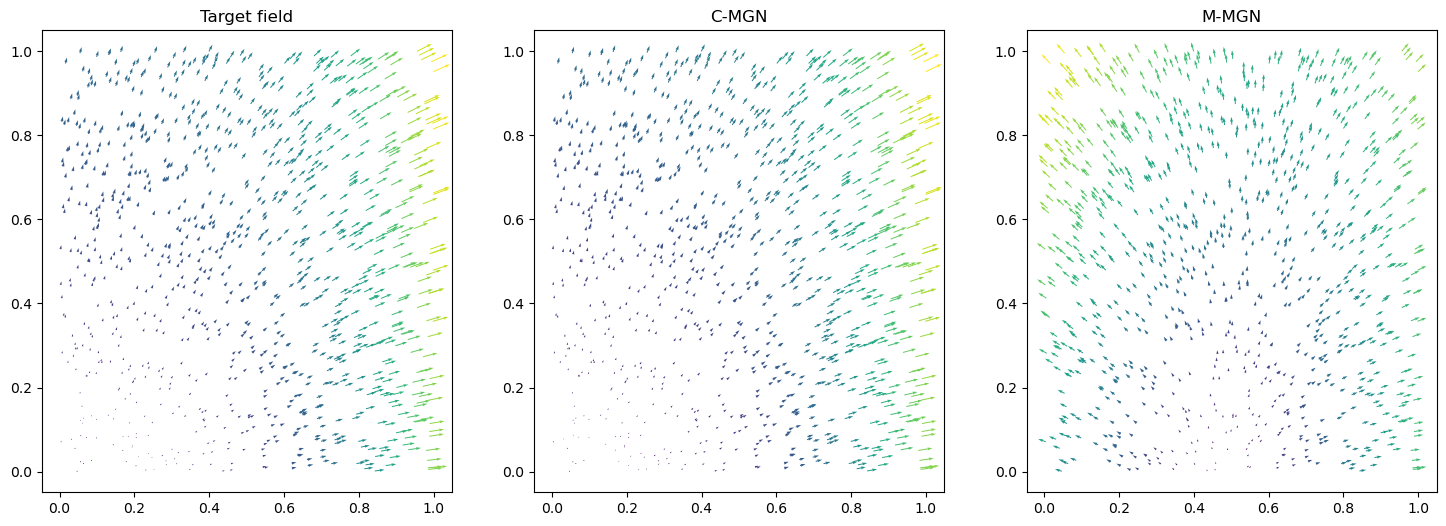

In [48]:
# Visualize the learned fields

fig,axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

# calculate fields
space = torch.rand(size=(1000,2)).to(device)
z = g(space)
z_c = model_CMGN(space)
z_m = model_MMGN(space)

# move to cpu for plotting
space = space.cpu()
z = z.cpu()
z_c = z_c.detach().cpu()
z_m = z_m.detach().cpu()

# true gradient field
z = g(space).cpu()
p = axs[0].quiver(space[:,0],space[:,1], z[:,0],z[:,1],z.norm(dim=1))
axs[0].set_title('Target field')
# axs[0].colorbar(p)

# C-MGN
p = axs[1].quiver(space[:,0],space[:,1], z_c[:,0],z_c[:,1],z_c.norm(dim=1))
axs[1].set_title('C-MGN')
# axs[1].colorbar(p)

# M-MGN
p = axs[2].quiver(space[:,0],space[:,1], z_m[:,0],z_m[:,1],z_m.norm(dim=1))
axs[2].set_title('M-MGN')
# axs[2].colorbar(p)

plt.show()

## 3. Optimal coupling
We consider the classical Monge problem of transporting a gaussian distribution to another one under the Euclidian cost. Here we choose as in [1] the target distribution to be the standard gaussian one.

We can solve this problem minimizing different losses:
- the Wasserstein cost that has a closed form for 2 gaussians
- the transport cost between source to prediction
- the KL divergence between prediction and target 